# Import

In [84]:
import pandas as pd
from src.search.candidate_generator import CandidateGenerator
from src.search.contextual_bandit import ContextualBanditReranker
from src.utils.target_metrics import calculate_delta_ndcg_rewards, precision_at_k
from src.utils.target_metrics import get_serp_clicks, ndcg
from src.utils.items_data import ItemsData
from src.search.neural_bandit import NeuralBanditReranker
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ddsharafiev/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ddsharafiev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/ddsharafiev/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# Data import

In [85]:
data = pd.read_csv('data/csv/projects.csv')

items_data = ItemsData(df=data)
cg = CandidateGenerator(alpha=0.95, items_data=items_data)

users = pd.read_csv('data/csv/users.csv')

clicks = pd.read_csv('data/csv/clicks.csv')

Preprocessing done.
BM25 index built.
Embedding model loaded.
Embeddings generated.
FAISS index created.
CandidateGenerator initialized.


# Example with a query

In [86]:
query = "I want to find a project about recommender systems with audio or music"

candidates = cg.generate_candidates(query, top_k=50)

cb = ContextualBanditReranker(candidates=candidates, items_data=items_data)
cb.rerank(query)
cb_candidates = cb.get_page(0, 20)

serp_clicks = get_serp_clicks(1, clicks, candidates)
ndcg_score = ndcg(serp_clicks, k=len(candidates))
print(f"NDCG score for the SERP: {ndcg_score:.4f}")

serp_clicks = get_serp_clicks(1, clicks, cb_candidates)
ndcg_score = ndcg(serp_clicks, k=len(cb_candidates))
print(f"NDCG score for the Contextual Bandit Reranker: {ndcg_score:.4f}")

for item in cb_candidates[:5]:
    print(data.iloc[item[0]]['Name'], item[1])


NDCG score for the SERP: 0.5548
NDCG score for the Contextual Bandit Reranker: 0.6914
AutonomousDrift 0.016668624126343595
BookRecommendation 0.013014160686760746
Killah 0.0065442456161823
MusicMood 0.0063581942046322636
OutfitPredict 0.005336961403846855


# Contextual bandit learning

In [18]:
A, b = cb.A, cb.b

In [9]:
for epoch in range(100):
    print(f"Epoch {epoch+1}/100")
    for user_id in range(1, 5):
        query = users.loc[users['id'] == user_id, 'short_profile'].values[0]
        candidates = cg.generate_candidates(query, top_k=100)

        serp_clicks = get_serp_clicks(user_id, clicks, candidates)
        baseline_ndcg_score = ndcg(serp_clicks, k=len(candidates))

        cb = ContextualBanditReranker(candidates=candidates, items_data=items_data, A=A, b=b, regularization=0.1, small_sigma=0.05)
        cb.rerank(query)
        displayed_items = cb.get_page(0, 100)

        serp_clicks = get_serp_clicks(user_id, clicks, displayed_items)
        ndcg_score = ndcg(serp_clicks, k=len(displayed_items))

        updates = calculate_delta_ndcg_rewards(
            displayed_items=displayed_items,
            user_clicks_df=clicks,
            user_id=user_id,
            baseline_candidates=candidates, # Передаем весь список кандидатов от CG
            scale_factor=10.0
        )

        cb.update_batch(query, updates)

        print(f"My NDCG: {ndcg_score}, Baseline NDCG: {baseline_ndcg_score}")

Epoch 1/100
My NDCG: 0.5219053331261584, Baseline NDCG: 0.8935229912282503
My NDCG: 0.43342759516575724, Baseline NDCG: 0.9548985973738172
My NDCG: 0.4410508080708755, Baseline NDCG: 0.7688623902132022
My NDCG: 0.8968188297558539, Baseline NDCG: 0.9715144671217378
Epoch 2/100
My NDCG: 0.5226562000911484, Baseline NDCG: 0.8935229912282503
My NDCG: 0.43343734260053796, Baseline NDCG: 0.9548985973738172
My NDCG: 0.44261227258502633, Baseline NDCG: 0.7688623902132022
My NDCG: 0.8969721100692893, Baseline NDCG: 0.9715144671217378
Epoch 3/100
My NDCG: 0.522029832179199, Baseline NDCG: 0.8935229912282503
My NDCG: 0.43344995934735775, Baseline NDCG: 0.9548985973738172
My NDCG: 0.4419880779846228, Baseline NDCG: 0.7688623902132022
My NDCG: 0.8968629843371286, Baseline NDCG: 0.9715144671217378
Epoch 4/100
My NDCG: 0.5226019067323343, Baseline NDCG: 0.8935229912282503
My NDCG: 0.4336046152503653, Baseline NDCG: 0.9548985973738172
My NDCG: 0.4424362460742259, Baseline NDCG: 0.7688623902132022
My N

# Neural bandits

first is delta nDCG

second one is pairloss

In [87]:
nb = NeuralBanditReranker(candidates=[], items_data=items_data, epsilon=0.1, lr=0.001)

for epoch in range(100):
    print(f"Epoch {epoch+1}/100")
    for user_id in range(1, 5):
        query = users.loc[users['id'] == user_id, 'short_profile'].values[0]
        candidates = cg.generate_candidates(query, top_k=100)
        nb_current = NeuralBanditReranker(
            candidates=candidates, 
            items_data=items_data, 
            epsilon=0.1, 
            lr=0.001, 
            model=nb.model, 
            optimizer=nb.optimizer
        )

        nb_current.rerank(query)
        displayed_items = nb_current.get_page(0, 100)

        updates = calculate_delta_ndcg_rewards(
            displayed_items=displayed_items,
            user_clicks_df=clicks,
            user_id=user_id,
            baseline_candidates=candidates,
            scale_factor=10.0
        )

        nb_current.update_batch(query, updates)

        print(f"Updated Neural Bandit for user {user_id}")
        print(f"Current NDCG Scores: {ndcg(get_serp_clicks(user_id, clicks, displayed_items), k=len(displayed_items))}, Baseline NDCG: {ndcg(get_serp_clicks(user_id, clicks, candidates), k=len(candidates))}")
    

Epoch 1/100
Updated Neural Bandit for user 1
Current NDCG Scores: 0.4940947643280529, Baseline NDCG: 0.6592780030577838
Updated Neural Bandit for user 2
Current NDCG Scores: 0.6021776222817756, Baseline NDCG: 0.7202297037296865
Updated Neural Bandit for user 3
Current NDCG Scores: 0.44444659379376256, Baseline NDCG: 0.7891801434389121
Updated Neural Bandit for user 4
Current NDCG Scores: 0.3480440223479096, Baseline NDCG: 0.9041432799496735
Epoch 2/100
Updated Neural Bandit for user 1
Current NDCG Scores: 0.5042729951176916, Baseline NDCG: 0.6592780030577838
Updated Neural Bandit for user 2
Current NDCG Scores: 0.6064924968559959, Baseline NDCG: 0.7202297037296865
Updated Neural Bandit for user 3
Current NDCG Scores: 0.7025497373976699, Baseline NDCG: 0.7891801434389121
Updated Neural Bandit for user 4
Current NDCG Scores: 0.4103389029760391, Baseline NDCG: 0.9041432799496735
Epoch 3/100
Updated Neural Bandit for user 1
Current NDCG Scores: 0.5252268555480856, Baseline NDCG: 0.65927800

KeyboardInterrupt: 

Epoch 5/30 | Train NDCG: 0.4927 | Test NDCG: 0.6026
Epoch 10/30 | Train NDCG: 0.5245 | Test NDCG: 0.6344
Epoch 10/30 | Train NDCG: 0.5245 | Test NDCG: 0.6344
Epoch 15/30 | Train NDCG: 0.6398 | Test NDCG: 0.7151
Epoch 15/30 | Train NDCG: 0.6398 | Test NDCG: 0.7151
Epoch 20/30 | Train NDCG: 0.6063 | Test NDCG: 0.7129
Epoch 20/30 | Train NDCG: 0.6063 | Test NDCG: 0.7129
Epoch 25/30 | Train NDCG: 0.6446 | Test NDCG: 0.7505
Epoch 25/30 | Train NDCG: 0.6446 | Test NDCG: 0.7505
Epoch 30/30 | Train NDCG: 0.6552 | Test NDCG: 0.7497
Epoch 30/30 | Train NDCG: 0.6552 | Test NDCG: 0.7497


Epoch 5/30 | Train NDCG: 0.4927 | Test NDCG: 0.6026
Epoch 10/30 | Train NDCG: 0.5245 | Test NDCG: 0.6344
Epoch 10/30 | Train NDCG: 0.5245 | Test NDCG: 0.6344
Epoch 15/30 | Train NDCG: 0.6398 | Test NDCG: 0.7151
Epoch 15/30 | Train NDCG: 0.6398 | Test NDCG: 0.7151
Epoch 20/30 | Train NDCG: 0.6063 | Test NDCG: 0.7129
Epoch 20/30 | Train NDCG: 0.6063 | Test NDCG: 0.7129
Epoch 25/30 | Train NDCG: 0.6446 | Test NDCG: 0.7505
Epoch 25/30 | Train NDCG: 0.6446 | Test NDCG: 0.7505
Epoch 30/30 | Train NDCG: 0.6552 | Test NDCG: 0.7497
Epoch 30/30 | Train NDCG: 0.6552 | Test NDCG: 0.7497


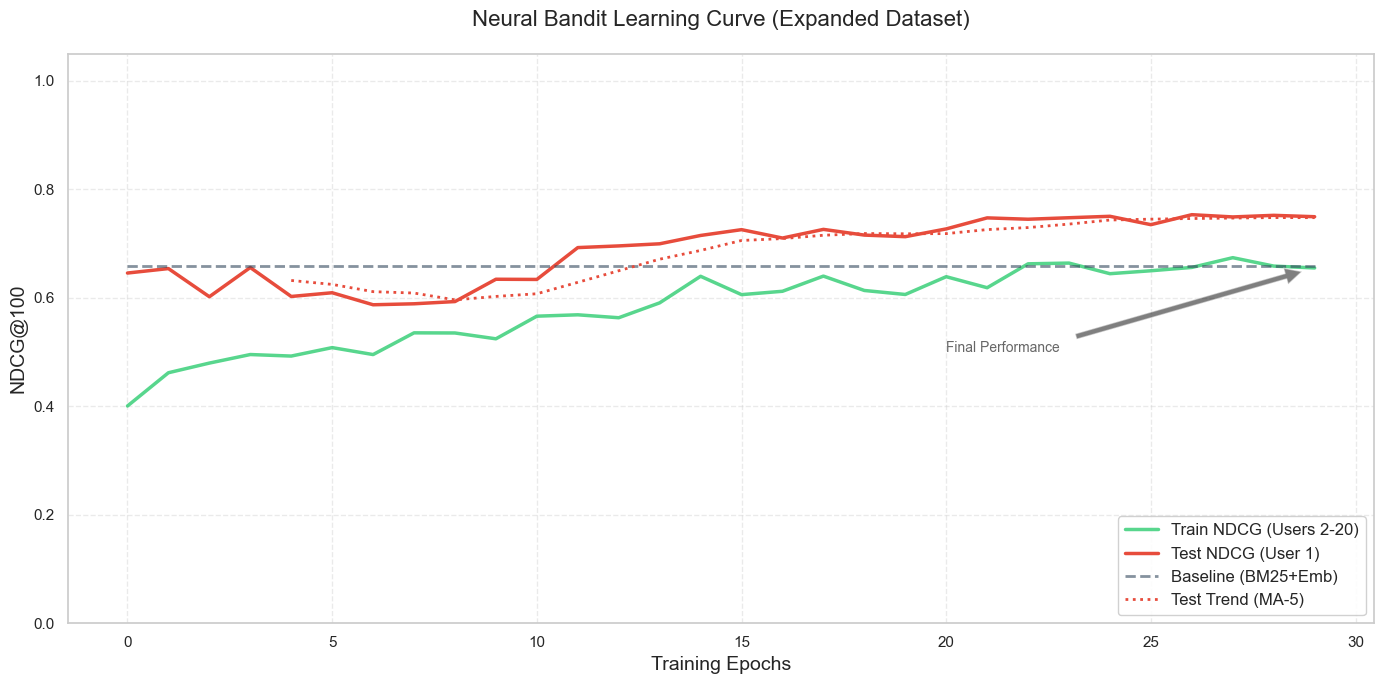

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from src.search.neural_bandit import NeuralBanditReranker

users = pd.read_csv('data/csv/users.csv')
clicks = pd.read_csv('data/csv/clicks.csv')

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

nb = NeuralBanditReranker(candidates=[], items_data=items_data, epsilon=0.1, lr=0.001)

history = {
    'train_ndcg': [],
    'test_ndcg': [],
    'baseline_ndcg': []
}

epochs = 30
train_user_ids = list(range(2, 56)) 

for epoch in range(epochs):
    epoch_train_ndcg = []
    
    np.random.shuffle(train_user_ids)
    
    for user_id in train_user_ids:
        try:
            query = users.loc[users['id'] == user_id, 'short_profile'].values[0]
        except IndexError:
            continue
            
        candidates = cg.generate_candidates(query, top_k=100)
        
        nb_current = NeuralBanditReranker(
            candidates=candidates, 
            items_data=items_data, 
            epsilon=0.1, 
            lr=0.001, 
            model=nb.model, 
            optimizer=nb.optimizer
        )

        nb_current.rerank(query)
        displayed_items = nb_current.get_page(0, 100)
        clicks_list = get_serp_clicks(user_id, clicks, displayed_items)
        
        nb_current.update_pairwise(query, displayed_items, clicks_list)
        
        epoch_train_ndcg.append(ndcg(clicks_list, k=len(displayed_items)))
    
    history['train_ndcg'].append(np.mean(epoch_train_ndcg))

    user_id = 1 
    query = users.loc[users['id'] == user_id, 'short_profile'].values[0]
    candidates = cg.generate_candidates(query, top_k=100)
    
    baseline_score = ndcg(get_serp_clicks(user_id, clicks, candidates), k=len(candidates))
    history['baseline_ndcg'].append(baseline_score)

    nb_current = NeuralBanditReranker(
        candidates=candidates, 
        items_data=items_data, 
        epsilon=0.0,
        lr=0.001,
        model=nb.model, 
        optimizer=nb.optimizer
    )
    nb_current.rerank(query)
    displayed_items = nb_current.get_page(0, 100)
    clicks_list = get_serp_clicks(user_id, clicks, displayed_items)
    
    history['test_ndcg'].append(ndcg(clicks_list, k=len(displayed_items)))
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs} | Train NDCG: {history['train_ndcg'][-1]:.4f} | Test NDCG: {history['test_ndcg'][-1]:.4f}")

plt.figure(figsize=(14, 7))

plt.plot(history['train_ndcg'], label=f'Train NDCG (Users 2-{train_user_ids[-1]})', color='#2ecc71', linewidth=2.5, alpha=0.8)
plt.plot(history['test_ndcg'], label='Test NDCG (User 1)', color='#e74c3c', linewidth=2.5)
plt.plot(history['baseline_ndcg'], label='Baseline (BM25+Emb)', color='#34495e', linestyle='--', linewidth=2, alpha=0.6)

window_size = 5
if len(history['test_ndcg']) >= window_size:
    smoothed_test = np.convolve(history['test_ndcg'], np.ones(window_size)/window_size, mode='valid')
    plt.plot(range(window_size-1, len(history['test_ndcg'])), smoothed_test, 
             label=f'Test Trend (MA-{window_size})', color='#e74c3c', linestyle=':', linewidth=2)

plt.title('Neural Bandit Learning Curve (Expanded Dataset)', fontsize=16, pad=20)
plt.xlabel('Training Epochs', fontsize=14)
plt.ylabel('NDCG@100', fontsize=14)
plt.legend(fontsize=12, loc='lower right', frameon=True, framealpha=0.9)
plt.grid(True, linestyle='--', alpha=0.4)
plt.ylim(0, 1.05)

plt.annotate('Final Performance', 
             xy=(epochs-1, history['train_ndcg'][-1]), 
             xytext=(epochs-10, 0.5),
             arrowprops=dict(facecolor='black', shrink=0.05, alpha=0.5),
             fontsize=10, alpha=0.7)

plt.tight_layout()
plt.show()